04b: Version with PCA

2021-10-25: 
  - Testing MLFlow integration
  - Testing 12 clusters and poly degree 3 incl poly for clusters
  - Started new approach for evaluation metrics (not fully implemented yet)
  - Changed to conda environment (with pip only dependencies)

In [15]:
# The rest of the modules are loaded when required.
# To ensure a standalone character (for easier reusability).

import os # for detecting CPU cores
import configparser # to load standard config and parameters
import pandas as pd
import numpy as np
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px

import mlflow
import mlflow.xgboost
from urllib.parse import urlparse

# Debugging
from icecream import ic

warnings.filterwarnings('ignore')
%load_ext watermark
%matplotlib inline

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [16]:
# importing the tensorflow package
import tensorflow as tf

# Checking GPU support
print(tf.test.is_built_with_cuda()) # True
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)) # True
print(tf.config.list_physical_devices('GPU'))

True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
import os
import configparser

# Load external config file
config = configparser.ConfigParser()
config.read("../resources/config.ini")

PATH_DATA_RAW = config["PATHS"]["PATH_DATA_RAW"]
PATH_DATA_INT = config["PATHS"]["PATH_DATA_INT"]
PATH_DATA_PRO = config["PATHS"]["PATH_DATA_PRO"]
PATH_REPORTS = config["PATHS"]["PATH_REPORTS"]
PATH_MODELS = config["PATHS"]["PATH_MODELS"]
PATH_SUB = config["PATHS"]["PATH_SUB"]

# Telegram Bot
token = config["TELEGRAM"]["token"]
chat_id = config["TELEGRAM"]["chat_id"]
FILENAME_NB = "02_baseline_models" # for Telegram messages

# Set global randome state
rnd_state = 42

# Define available cpu cores
n_cpu = os.cpu_count()
print("Number of CPUs used:", n_cpu)

Number of CPUs used: 16


In [18]:
train_df = pd.read_csv(PATH_DATA_RAW+'train.csv',index_col=0)
test_df = pd.read_csv(PATH_DATA_RAW+'test.csv',index_col=0)
sample_df = pd.read_csv(PATH_DATA_RAW+'sample_submission.csv')

In [19]:
train_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,0,1,0,0,0,0,0,0,0,1
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,0,1,0,0,0,0,0,0,0,1
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,0,0,0,1,1,0,0,0,0,1
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0,0,0,0,1,0,0,0,0,1
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,0,1,1,0,1,0,0,1,0,1


In [20]:
memory_usage = train_df.memory_usage(deep=True) / 1024 ** 2
start_mem = memory_usage.sum()
start_mem

2189.63623046875

In [21]:
feature_cols = train_df.drop(['target'], axis=1).columns.tolist()
cnt_features = train_df.drop(['target'], axis=1).select_dtypes(exclude=['int64']).columns.tolist()
cat_features = train_df.drop(['target'], axis=1).select_dtypes(exclude=['float64']).columns.tolist()

ic(len(feature_cols))
ic(len(cnt_features))
ic(len(cat_features));

ic| len(feature_cols): 285
ic| len(cnt_features): 240
ic| len(cat_features): 45


In [22]:
#useful_features = useful_features = ["f22", "f179", "f69", "f58", "f214", "f78", "f136", "f156", "f8", "f3", "f77", "f200", "f92", "f185", "f142", "f115", "f284"]
useful_features = pd.read_csv(PATH_DATA_INT+'features_selected_6way_140.csv')['Feature'].head(13).tolist()
ic(len(useful_features));

ic| len(useful_features): 13


In [23]:
#feature_cols = useful_features

In [24]:
train_df[cnt_features] = train_df[cnt_features].astype('float32')
train_df[cat_features] = train_df[cat_features].astype('uint8')

test_df[cnt_features] = test_df[cnt_features].astype('float32')
test_df[cat_features] = test_df[cat_features].astype('uint8')

In [25]:
memory_usage = train_df.memory_usage(deep=True) / 1024 ** 2
end_mem = memory_usage.sum()
end_mem

973.7014770507812

In [26]:
print("Mem. usage decreased from {:.2f} MB to {:.2f} MB ({:.2f}% reduction)".format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))

Mem. usage decreased from 2189.64 MB to 973.70 MB (55.53% reduction)


# Feature Engineering

## KMeans Clustering

In [27]:
from sklearn.cluster import KMeans

n_clusters_1 = 12
cluster_cols = [f"cluster{i+1}" for i in range(n_clusters_1)]
kmeans = KMeans(n_clusters=n_clusters_1, n_init=50, max_iter=500, random_state=rnd_state)

ic(n_clusters_1)
#ic(cluster_cols);

ic| n_clusters_1: 12
ic| cluster_cols: ['cluster1',
                   'cluster2',
                   'cluster3',
                   'cluster4',
                   'cluster5',
                   'cluster6',
                   'cluster7',
                   'cluster8',
                   'cluster9',
                   'cluster10',
                   'cluster11',
                   'cluster12']


In [28]:
# cluster distance instead of cluster number

# train
X_cd = kmeans.fit_transform(train_df[useful_features])
X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=train_df.index)
train = train_df.join(X_cd)

# test
X_cd = kmeans.transform(test_df[useful_features])
X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=test_df.index)
test = test_df.join(X_cd)

In [29]:
feature_cols += cluster_cols
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12
id,,,,,,,,,,,,,,,,,,,,,
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,0.441040,0.293589,1.129853,0.182741,1.031259,0.436314,1.012759,1.078041,0.239853,0.220649
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,0.366144,0.261555,1.147521,0.281341,1.030607,0.358476,1.067667,1.058062,0.423008,0.393181
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,1.176883,1.132071,0.177941,1.127270,0.522586,1.176573,0.482276,0.601561,1.138741,1.109048
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0.365145,0.257832,1.137282,0.307820,1.032645,0.442391,1.024758,1.055140,0.319115,0.196916
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,1.187567,1.077309,0.702856,1.145182,0.409222,1.188239,0.577344,0.618212,1.128277,1.159471


In [30]:
ic(len(feature_cols))
#ic(feature_cols);

ic| len(feature_cols): 297


297

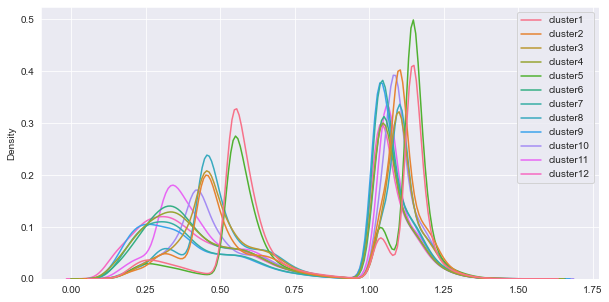

In [31]:
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10,5))
sns.kdeplot(data=train[cluster_cols])
plt.show()

## PCA

In [32]:
"""
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(train[useful_features])
T_pca = pca.transform(test[useful_features])

pca_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]

X_pca = pd.DataFrame(X_pca, columns=pca_cols, index=train.index)
T_pca = pd.DataFrame(T_pca, columns=pca_cols, index=test.index)

train = pd.concat([train, X_pca], axis=1)
test = pd.concat([test, T_pca], axis=1)
"""

'\nfrom sklearn.decomposition import PCA\n\npca = PCA()\nX_pca = pca.fit_transform(train[useful_features])\nT_pca = pca.transform(test[useful_features])\n\npca_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]\n\nX_pca = pd.DataFrame(X_pca, columns=pca_cols, index=train.index)\nT_pca = pd.DataFrame(T_pca, columns=pca_cols, index=test.index)\n\ntrain = pd.concat([train, X_pca], axis=1)\ntest = pd.concat([test, T_pca], axis=1)\n'

In [33]:
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12
id,,,,,,,,,,,,,,,,,,,,,
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,0.441040,0.293589,1.129853,0.182741,1.031259,0.436314,1.012759,1.078041,0.239853,0.220649
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,0.366144,0.261555,1.147521,0.281341,1.030607,0.358476,1.067667,1.058062,0.423008,0.393181
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,1.176883,1.132071,0.177941,1.127270,0.522586,1.176573,0.482276,0.601561,1.138741,1.109048
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0.365145,0.257832,1.137282,0.307820,1.032645,0.442391,1.024758,1.055140,0.319115,0.196916
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,1.187567,1.077309,0.702856,1.145182,0.409222,1.188239,0.577344,0.618212,1.128277,1.159471


In [34]:
"""
loadings = pd.DataFrame(pca.components_, index=pca_cols, columns=train[useful_features].columns)
loadings.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])
"""

"\nloadings = pd.DataFrame(pca.components_, index=pca_cols, columns=train[useful_features].columns)\nloadings.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])\n"

In [35]:
#feature_cols += ["PC1"]
#feature_cols += pca_cols


## Polynomial Features

- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

### Useful Features

In [36]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, interaction_only=True)

X_poly = poly.fit_transform(train[useful_features])
T_poly = poly.transform(test[useful_features])

poly_cols = [f"poly{i+1}" for i in range(X_poly.shape[1])]

X_poly_df = pd.DataFrame(X_poly, columns=poly_cols, index=train.index)
T_poly_df = pd.DataFrame(T_poly, columns=poly_cols, index=test.index)

train = pd.concat([train, X_poly_df], axis=1)
test = pd.concat([test, T_poly_df], axis=1)


In [37]:
#feature_cols += ["poly79", "poly82", "poly66", "poly32", "poly81", "poly80", "poly42", "poly78", "poly59"]
feature_cols += poly_cols
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,poly369,poly370,poly371,poly372,poly373,poly374,poly375,poly376,poly377,poly378
id,,,,,,,,,,,,,,,,,,,,,
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,0.000680,0.000647,0.000158,0.004962,0.001212,0.001153,0.080186,0.019589,0.018634,0.142876
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,0.001157,0.001096,0.000310,0.117024,0.033062,0.031302,0.005771,0.001630,0.001544,0.164867
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,0.000050,0.000101,0.000031,0.003605,0.001091,0.002223,0.003721,0.001126,0.002295,0.081546
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0.000117,0.000109,0.000038,0.007411,0.002601,0.002439,0.009255,0.003248,0.003046,0.206254
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,0.000635,0.000604,0.000195,0.002763,0.000892,0.000849,0.133969,0.043246,0.041156,0.188262


### Clusters

- TODO: Perform poly for clusters

## Add New Features

In [38]:
"""
def add_feature(df):
    df["new_f1"] = df["cluster1"]/df["cluster3"]
    df["new_f2"] = df["cluster5"]/df["cluster6"]
    df["new_f3"] = df["cluster5"]/df["cluster2"]
    df["new_f4"] = df["cluster6"]/df["cluster4"]
    return df

new_features = ["new_f1", "new_f2", "new_f3","new_f4"]
train = add_feature(train)
test = add_feature(test)
feature_cols += new_features
train.head()
"""

'\ndef add_feature(df):\n    df["new_f1"] = df["cluster1"]/df["cluster3"]\n    df["new_f2"] = df["cluster5"]/df["cluster6"]\n    df["new_f3"] = df["cluster5"]/df["cluster2"]\n    df["new_f4"] = df["cluster6"]/df["cluster4"]\n    return df\n\nnew_features = ["new_f1", "new_f2", "new_f3","new_f4"]\ntrain = add_feature(train)\ntest = add_feature(test)\nfeature_cols += new_features\ntrain.head()\n'

## Mutual Information

In [39]:
from sklearn.feature_selection import mutual_info_regression

x = train.iloc[:5000,:][feature_cols] #.copy()
y = train.iloc[:5000,:]['target'] #.copy()
mi_scores = mutual_info_regression(x, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
mi_scores = mi_scores.sort_values(ascending=False)

In [40]:
import plotly.figure_factory as ff
import plotly.express as px

top = 20
fig = px.bar(mi_scores, x=mi_scores.values[:top], y=mi_scores.index[:top])
fig.update_layout(
    title=f"Top {top} Strong Relationships Between Feature Columns and Target Column",
    xaxis_title="Relationship with Target",
    yaxis_title="Feature Columns",
    yaxis={'categoryorder':'total ascending'},
    colorway=["blue"]
)
fig.show()

In [41]:
ic(len(feature_cols))

ic| len(feature_cols): 675


675

# Model Training

## Functions

In [42]:
# TODO: New approach for evaluation metrics (not fully implemented yet)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

def evaluation_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)

    print("RMSE: %s" % rmse)
    print("MAE: %s" % mae)
    print("R2: %s" % r2)

    return rmse, mae, r2

## Baseline Score

In [44]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X = train.drop(["target"], axis=1)
X = X[feature_cols].values
y = train["target"].values

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=rnd_state, stratify=y
)

print("--")
# mlflow.autolog()
# mlflow.xgboost.autolog()
mlflow.start_run()
run = mlflow.active_run()

# Log text to a file under the run's root artifact directory
mlflow.log_text("Test", "comments.txt")

# Print run id
print("run_id: {}; status: {}\n".format(run.info.run_id, run.info.status))

params = {
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    "gpu_id": 0,
    # "n_jobs": n_cpu,
    "predictor": "gpu_predictor",
    "n_estimators": 10000,
    "learning_rate": 0.01063045229441343,
    "gamma": 0.24652519525750877,
    "max_depth": 4,
    "seed": rnd_state,
    "min_child_weight": 366,
    "subsample": 0.6423040816299684,
    "colsample_bytree": 0.7751264493218339,
    "colsample_bylevel": 0.8675692743597421,
    "use_label_encoder": False,
    "lambda": 0,
    "alpha": 10,
}

clf = XGBClassifier(**params)
_ = clf.fit(X_train, y_train)

# train_roc_auc_score = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
# valid_roc_auc_score = roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])

y_predicted = clf.predict(X_valid)
roc_auc = roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])

rmse, mae, r2 = evaluation_metrics(y_valid, y_predicted)
print("ROC AUC Score: %s" % roc_auc)

# print(train_roc_auc_score) # 0.8617102921465771 (fs18, no_new_f), same with fs16, and 3 new_f
# print(roc_auc) # 0.8558234199478256 (fs18, no_new_f), same with fs16, and 3 new_f

# incl.PCA and new features: ROC AUC Score: 0.8574099209176737


--
run_id: a9cc7c1193e44fc3b7971bf25a885268; status: RUNNING
ROC AUC Score: 0.8569846382791737
RMSE: 0.4797707786016151
MAE: 0.23018
R2: 0.07927913726245395


In [45]:
# MLFlow: Get metrics - TODO: Test mlflow.autolog()
mlflow.log_params(params)
mlflow.log_metric("rmse", rmse)
mlflow.log_metric("r2", r2)
mlflow.log_metric("mae", mae)
mlflow.log_metric("roc_auc_score", roc_auc)

#features =" ".join(str(elem) for elem in feature_cols)
features = str(feature_cols)

with open("features.txt", 'w') as f:
    f.write(features)
    
mlflow.log_artifact("features.txt", artifact_path="features")

tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

# Register Experiment
if tracking_url_type_store != "file":
    # Register the model
    # There are other ways to use the Model Registry, which depends on the use case,
    # please refer to the doc for more information:
    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
    
    mlflow.xgboost.log_model(
        xgb_model=clf,
        artifact_path="xgboost-model",
        registered_model_name="XGBClassifier",
    )

else:
    print('Store type: file')
    mlflow.xgboost.log_model(clf, "model")


Store type: file


In [46]:
# End run and get status
mlflow.end_run()
run = mlflow.get_run(run.info.run_id)
print("run_id: {}; status: {}".format(run.info.run_id, run.info.status))
print("--")

# Check for any active runs
print("Active run: {}".format(mlflow.active_run()))

run_id: a9cc7c1193e44fc3b7971bf25a885268; status: FINISHED
--
Active run: None


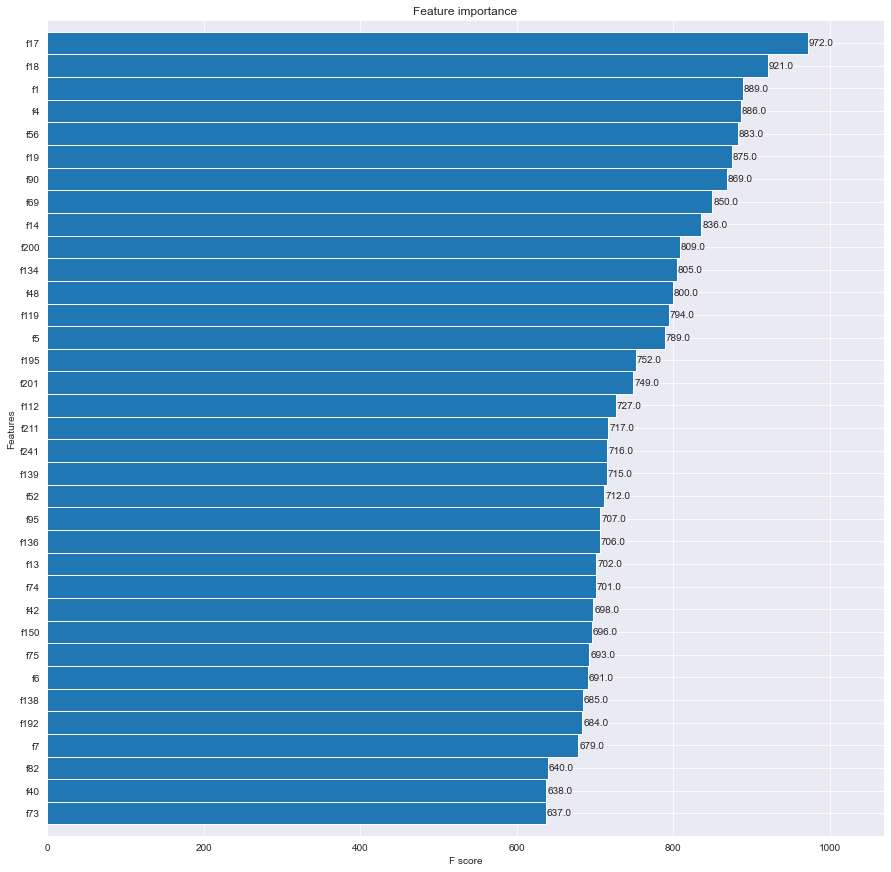

In [47]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# plot feature importance
fig, ax = plt.subplots(figsize=(15, 15))
plot_importance(clf, max_num_features=35, height=1, ax=ax)
plt.show()

# Creating Kfolds

In [56]:
from sklearn.model_selection import StratifiedKFold

folds = 5
train["kfold"] = -1
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rnd_state)

# Adding folds to dataset
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(train,train["target"])):
    train.loc[valid_indicies, "kfold"] = fold

In [57]:
train['kfold'].value_counts()

3    200000
2    200000
4    200000
0    200000
1    200000
Name: kfold, dtype: int64

In [58]:
print("--")
# mlflow.autolog()
# mlflow.xgboost.autolog()
mlflow.start_run()
run = mlflow.active_run()

# Log text to a file under the run's root artifact directory
mlflow.log_text("Test", "comments.txt")

# Print run id
print("run_id: {}; status: {}\n".format(run.info.run_id, run.info.status))

--
run_id: f64d06226bb94f2fb2b33350b7a40692; status: RUNNING



In [59]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import time

final_test_predictions = []
scores = []

for fold in range(folds):
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()
    x_test = test[feature_cols].copy()

    y_train = x_train["target"]
    y_valid = x_valid["target"]

    x_train = x_train[feature_cols]
    x_valid = x_valid[feature_cols]

    xgb_params = {
        "eval_metric": "auc",
        "objective": "binary:logistic",
        "tree_method": "gpu_hist",
        "gpu_id": 0,
        #"n_jobs": n_cpu,
        "predictor": "gpu_predictor",
        "n_estimators": 10000,
        "learning_rate": 0.01063045229441343,
        "gamma": 0.24652519525750877,
        "max_depth": 4,
        "seed": rnd_state,
        "min_child_weight": 366,
        "subsample": 0.6423040816299684,
        "colsample_bytree": 0.7751264493218339,
        "colsample_bylevel": 0.8675692743597421,
        "use_label_encoder": False,
        "lambda": 0,
        "alpha": 10,
    }

    model = XGBClassifier(**xgb_params)
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=False)

    preds_train = model.predict_proba(x_train)[:, 1]
    preds_valid = model.predict_proba(x_valid)[:, 1]
    auc_train = roc_auc_score(y_train, preds_train)
    auc = roc_auc_score(y_valid, preds_valid)
    print("Fold", fold, ", train:", f"{auc_train:.6f}", ", valid:", f"{auc:.6f}")
    scores.append(auc)

    preds_test = model.predict_proba(x_test)[:, 1]
    final_test_predictions.append(preds_test)


print("AVG AUC:", np.mean(scores))

Fold 0 , train: 0.870153 , valid: 0.858381
Fold 1 , train: 0.870774 , valid: 0.855404
Fold 2 , train: 0.870389 , valid: 0.857206
Fold 3 , train: 0.870838 , valid: 0.855695
Fold 4 , train: 0.870575 , valid: 0.856448
AVG AUC: 0.8566269081302578


In [60]:
# MLFlow: Get metrics
# TODO: Test mlflow.autolog()
mlflow.log_params(params)
#mlflow.log_metric("rmse", rmse)
#mlflow.log_metric("r2", r2)
#mlflow.log_metric("mae", mae)
mlflow.log_metric("AVG AUC", np.mean(scores))

#features =", ".join(str(elem) for elem in feature_cols)
features = str(feature_cols)

with open("features.txt", 'w') as f:
    f.write(features)
    
mlflow.log_artifact("features.txt", artifact_path="features")

tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

# Register Experiment
if tracking_url_type_store != "file":
    # Register the model
    # There are other ways to use the Model Registry, which depends on the use case,
    # please refer to the doc for more information:
    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
    
    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path="xgboost-model",
        registered_model_name="XGBClassifier",
    )

else:
    print('Store type: file')
    mlflow.xgboost.log_model(model, "model")


Store type: file


In [61]:
# End run and get status
mlflow.end_run()
run = mlflow.get_run(run.info.run_id)
print("run_id: {}; status: {}".format(run.info.run_id, run.info.status))
print("--")

# Check for any active runs
print("Active run: {}".format(mlflow.active_run()))

run_id: f64d06226bb94f2fb2b33350b7a40692; status: FINISHED
--
Active run: None


#  Submit results

- 2021-10-20_submission_kmean-pca-fs17-xbg-nop.csv: 0.8569970265985022 | **0.85626**
- 2021-10-20_submission_kmean-3pca-fs17-xbg-nop.csv: 0.8568950821125828 | 0.85619
- 2021-10-20_submission_kmean-ALLpca-fs13-xbg-nop.csv: 0.8567778822323093 | not submitted
- 2021-10-20_submission_13fs-kmean-2pca-4nf-xbg-nop.csv: 0.8568443738048714 | not submitted
- 2021-10-20_submission_49fs-kmean-2pca-4nf-xbg-nop.csv: 0.8567888578426363 | 0.85599
- 2021-10-20_submission_13fs-kmean-1pca-4nf-poly-xbg-nop.csv: 0.8568639280432698 | 0.85615
- 2021-10-25_submission_f64d06226bb94f2fb2b33350b7a40692.csv: 0.8566269081302578 | 0.85600

In [64]:
import numpy as np
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
now = now.strftime("%Y-%m-%d")

objective = str(run.info.run_id)

curr_submission_fn = f"{now}_submission_{objective}.csv"

sample_df['target'] = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_df.to_csv(PATH_SUB + curr_submission_fn, index=False)

print(curr_submission_fn)


2021-10-25_submission_f64d06226bb94f2fb2b33350b7a40692.csv


In [65]:
!kaggle competitions submit tabular-playground-series-oct-2021 -f {PATH_SUB+curr_submission_fn} -m {curr_submission_fn}

Successfully submitted to Tabular Playground Series - Oct 2021


  0%|          | 0.00/9.36M [00:00<?, ?B/s]
  0%|          | 8.00k/9.36M [00:00<07:18, 22.4kB/s]
  1%|          | 96.0k/9.36M [00:00<00:42, 229kB/s] 
  1%|▏         | 136k/9.36M [00:01<01:11, 135kB/s] 
  2%|▏         | 168k/9.36M [00:01<01:04, 149kB/s]
  2%|▏         | 192k/9.36M [00:01<01:31, 105kB/s]
  2%|▏         | 216k/9.36M [00:01<01:18, 122kB/s]
  3%|▎         | 240k/9.36M [00:01<01:08, 140kB/s]
  3%|▎         | 264k/9.36M [00:01<01:00, 157kB/s]
  3%|▎         | 304k/9.36M [00:02<00:47, 200kB/s]
  4%|▎         | 336k/9.36M [00:02<00:43, 216kB/s]
  4%|▍         | 368k/9.36M [00:02<00:39, 239kB/s]
  4%|▍         | 408k/9.36M [00:02<00:34, 273kB/s]
  5%|▍         | 448k/9.36M [00:02<00:30, 303kB/s]
  5%|▌         | 480k/9.36M [00:02<00:30, 305kB/s]
  5%|▌         | 512k/9.36M [00:02<00:30, 306kB/s]
  6%|▌         | 552k/9.36M [00:02<00:29, 315kB/s]
  6%|▋         | 600k/9.36M [00:02<00:26, 342kB/s]
  7%|▋         | 640k/9.36M [00:03<00:28, 326kB/s]
  7%|▋         | 688k/9.36M [00:

 76%|███████▌  | 7.08M/9.36M [00:21<00:06, 349kB/s]
 76%|███████▌  | 7.12M/9.36M [00:21<00:06, 359kB/s]
 76%|███████▋  | 7.16M/9.36M [00:21<00:06, 341kB/s]
 77%|███████▋  | 7.20M/9.36M [00:21<00:06, 361kB/s]
 77%|███████▋  | 7.24M/9.36M [00:21<00:05, 373kB/s]
 78%|███████▊  | 7.28M/9.36M [00:21<00:05, 370kB/s]
 78%|███████▊  | 7.32M/9.36M [00:22<00:06, 345kB/s]
 79%|███████▊  | 7.37M/9.36M [00:22<00:05, 377kB/s]
 79%|███████▉  | 7.41M/9.36M [00:22<00:05, 353kB/s]
 80%|███████▉  | 7.45M/9.36M [00:22<00:05, 357kB/s]
 80%|███████▉  | 7.48M/9.36M [00:22<00:05, 357kB/s]
 80%|████████  | 7.52M/9.36M [00:22<00:05, 334kB/s]
 81%|████████  | 7.56M/9.36M [00:22<00:05, 349kB/s]
 81%|████████  | 7.60M/9.36M [00:22<00:05, 359kB/s]
 82%|████████▏ | 7.64M/9.36M [00:23<00:04, 362kB/s]
 82%|████████▏ | 7.68M/9.36M [00:23<00:04, 360kB/s]
 82%|████████▏ | 7.72M/9.36M [00:23<00:04, 365kB/s]
 83%|████████▎ | 7.76M/9.36M [00:23<00:04, 360kB/s]
 83%|████████▎ | 7.80M/9.36M [00:23<00:04, 353kB/s]
 84%|███████